In [1]:
import matplotlib.pyplot as plt
import pandas as pd
#import modin.pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import gc
from sklearn.metrics import confusion_matrix, roc_curve 
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# df = pd.read_csv("output_adam.csv")
# df_label = pd.read_csv("mirai_labels.csv")
# df["alert"] = df_label
# df.head()

In [2]:
df = pd.read_csv("df_train.csv")

/tmp/ipykernel_80926/2622340693.py:1: DtypeWarning: Columns (24,25,26,27,28,30,38,39,40,41,42,44,46,48,50,51,52,53,55,56,57,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_train.csv")


In [3]:
df.columns

Index(['frame.number', 'frame.len', 'frame.time', 'frame.time_epoch',
       'frame.protocols', 'eth.src', 'eth.dst', 'eth.type', 'ip.src', 'ip.dst',
       'ip.len', 'ip.ttl', 'ip.flags', 'ip.frag_offset', 'ip.proto',
       'ip.version', 'ip.dsfield', 'ip.checksum', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.flags', 'tcp.flags.syn',
       'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', 'tcp.window_size',
       'tcp.checksum', 'tcp.stream', 'udp.srcport', 'udp.dstport',
       'udp.length', 'udp.checksum', 'icmp.type', 'icmp.code', 'icmp.checksum',
       'http.request.method', 'http.request.uri', 'http.request.version',
       'http.request.full_uri', 'http.response.code', 'http.user_agent',
       'http.content_length_header', 'http.content_type', 'http.cookie',
       'http.host', 'http.referer', 'http.location', 'http.authorization',
       'http.connection', 'dns.qry.name', 'dns.qry.type', 'dns.qry.class',
       'dns.flags.response', 'dns.f

In [3]:
df["frame.time"].iloc[1]

'Aug  9, 2017 10:57:35.416698000 Środkowoeuropejski czas letni'

In [3]:
def ordinalize_packets(packet_data, column="ip"):
    src_col = f"{column}.src"
    dst_col = f"{column}.dst"
    if 'frame.number' not in packet_data.columns or src_col not in packet_data.columns or dst_col not in packet_data.columns:
        raise ValueError("DataFrame must contain 'frame.number' and  columns")

    out_src = packet_data.reset_index().groupby([src_col])['index'].min()
    out_dst = packet_data.reset_index().groupby([dst_col])['index'].min() + 0.5
    out = pd.concat([out_src, out_dst], axis=0).sort_values()
    out = out[~out.index.duplicated(keep='first')]
    out.iloc[:] = out.reset_index(name="ip").index
    out = out.astype(int)
    mappings = out.to_dict()
    return mappings
    #packet_data.loc[:, src_col] = packet_data[src_col].replace(mappings).astype(int)
    #packet_data.loc[:, dst_col] = packet_data[dst_col].replace(mappings).astype(int)

In [4]:
features = ["frame.number", "frame.len", 'frame.time', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'ip.len', 'ip.ttl',
            'tcp.srcport', 'tcp.dstport',
            'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', "alert", "udp.srcport", "udp.dstport"]
df = df[features]
df["frame.len"] /= 65535
df["ip.len"] /= 65535
df["ip.ttl"] /= 255
df["tcp.srcport"] /= 65535
df["tcp.dstport"] /= 65535
df["udp.srcport"] /= 65535
df["udp.dstport"] /= 65535
df["frame.time"] = df["frame.time"].str.replace(" Środkowoeuropejski czas letni", "")#mój PCAP był po POlsku Pudzian byłby dumny :peepoGlad# CEST
df["frame.time"] = df["frame.time"].str.replace(" Środkowoeuropejski czas stand.", "")
df["frame.time"] = df["frame.time"].str.replace(" CEST", "")
df["frame.time"] = pd.to_datetime(df["frame.time"])
df['dow_sin'] = np.sin(2 * np.pi * df["frame.time"].dt.dayofweek / 6)
df['dow_cos'] = np.cos(2 * np.pi * df["frame.time"].dt.dayofweek / 6)
df['hour_sin'] = np.sin(2 * np.pi * df["frame.time"].dt.hour / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df["frame.time"].dt.hour / 24.0)
df["minute_sin"] = np.sin(2 * np.pi * df["frame.time"].dt.minute / 60)
df["minute_cos"] = np.cos(2 * np.pi * df["frame.time"].dt.minute / 60)
df["second_sin"] = np.sin(2 * np.pi * df["frame.time"].dt.second / 60)
df["second_cos"] = np.cos(2 * np.pi * df["frame.time"].dt.second / 60)
df["ms_sin"] = np.sin(2 * np.pi * df["frame.time"].dt.microsecond / 1000000)
df["ms_cos"] = np.cos(2 * np.pi * df["frame.time"].dt.microsecond / 1000000)
df = df.fillna(0)  # only tcp is left
df = df.drop(columns=["frame.time"])

In [76]:
df.head(128)

,frame.number,frame.len,eth.src,eth.dst,ip.src,ip.dst,ip.len,ip.ttl,tcp.srcport,tcp.dstport,...,dow_sin,dow_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos
0,1236045,0.023102,ac:9b:0a:fc:2a:73,00:a0:de:f1:88:6e,192.168.2.15,192.168.100.5,0.022889,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.258819,-0.965926,0.669131,7.431448e-01,1.000000e+00,2.832769e-16,-0.377139,-0.926157
1,84707,0.003189,10:4f:a8:70:22:7e,00:a0:de:f1:88:6e,192.168.2.13,192.168.100.5,0.002976,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.500000,-0.866025,-0.309017,9.510565e-01,-5.000000e-01,-8.660254e-01,0.499829,-0.866124
2,679170,0.005554,10:4f:a8:70:22:7e,00:a0:de:f1:88:6e,192.168.2.13,192.168.100.5,0.005341,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.258819,-0.965926,0.207912,9.781476e-01,7.431448e-01,-6.691306e-01,-0.122496,0.992469
3,2245698,0.023102,10:4f:a8:70:22:7e,00:a0:de:f1:88:6e,192.168.2.13,192.168.100.5,0.022889,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.258819,-0.965926,0.951057,-3.090170e-01,5.665539e-16,-1.000000e+00,0.266260,0.963901
4,2017908,0.000916,10:4f:a8:70:22:7e,00:a0:de:f1:88:6e,192.168.2.13,192.168.100.5,0.000687,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.258819,-0.965926,1.000000,2.832769e-16,-9.945219e-01,1.045285e-01,0.817640,0.575730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2029919,0.023102,10:4f:a8:70:22:7e,00:a0:de:f1:88:6e,192.168.2.13,192.168.100.5,0.022889,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.258819,-0.965926,1.000000,2.832769e-16,-5.877853e-01,8.090170e-01,0.995328,0.096548
124,530371,0.007355,10:4f:a8:70:22:7e,00:a0:de:f1:88:6e,192.168.2.13,192.168.100.5,0.007141,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.258819,-0.965926,0.104528,9.945219e-01,9.135455e-01,4.067366e-01,0.252996,0.967467
125,1071640,0.019745,ac:9b:0a:fc:2a:73,00:a0:de:f1:88:6e,192.168.2.15,192.168.100.5,0.019532,0.250980,0.006760,0.93135,...,0.866025,-0.5,0.258819,-0.965926,0.500000,8.660254e-01,-9.781476e-01,2.079117e-01,-0.996603,-0.082361
126,2014633,0.023102,ac:9b:0a:fc:2a:73,00:a0:de:f1:88:6e,192.168.2.15,192.168.100.5,0.022889,0.250980,0.000000,0.00000,...,0.866025,-0.5,0.258819,-0.965926,1.000000,2.832769e-16,-9.781476e-01,-2.079117e-01,-0.195349,0.980734


In [5]:
from torch.utils.data import Dataset
from tqdm import trange
from multiprocessing import Pool
import pickle

class NetworkDataset(Dataset):
    def __init__(self, data, window=128, mapping_ip=None, mapping_eth=None):
        p = Pool(processes=6, maxtasksperchild=10)
        self.data = data
        self.window = window
        if mapping_ip is None:
            self.mappings_ip = p.map(self.ordinal_ip, trange(len(self)))
        else:
            self.mappings_ip = pickle.load(open(mapping_ip, "rb"))
        if mapping_eth is None:
            self.mappings_eth = p.map(self.ordinal_eth, trange(len(self)))
        else:
            self.mappings_eth = pickle.load(open(mapping_eth, "rb"))
        p.close()
        p.join()
        exclude_cols = {'alert', 'frame.number', 'ip.src', 'ip.dst', 'eth.src', 'eth.dst'}
        self.feature_cols = [col for col in self.data.columns if col not in exclude_cols]
            
    def ordinal_ip(self, i):
        return ordinalize_packets(self.data[i:i+self.window], "ip")
    def ordinal_eth(self, i):
        return ordinalize_packets(self.data[i:i+self.window], "eth")
    
    def __getitem__(self, index):
        """packets = self.data[index:index + self.window]
        labels = packets['alert'].to_numpy().astype(np.float32)
        eth_src = packets["eth.src"].map(self.mappings_eth[index]).fillna(0).astype(int)
        eth_dst = packets["eth.dst"].map(self.mappings_eth[index]).fillna(0).astype(int)
        ip_src = packets["ip.src"].map(self.mappings_ip[index]).fillna(0).astype(int)
        ip_dst = packets["ip.dst"].map(self.mappings_ip[index]).fillna(0).astype(int)
        packets = packets.drop(columns=['alert', "frame.number"]).fillna(0)
        return (pd.concat([eth_src, eth_dst]).values, pd.concat([ip_src, ip_dst]).values,
                packets.drop(columns=["ip.src", "ip.dst", "eth.src", "eth.dst"]).values.astype("float32"), labels)"""
        packets = self.data[index:index + self.window]
        labels = packets['alert'].values.astype(np.float32)
        
        eth_src = np.vectorize(self.mappings_eth[index].get)(packets["eth.src"].values)
        eth_dst = np.vectorize(self.mappings_eth[index].get)(packets["eth.dst"].values)
        ip_src = np.vectorize(self.mappings_ip[index].get)(packets["ip.src"].values)
        ip_dst = np.vectorize(self.mappings_ip[index].get)(packets["ip.dst"].values)
    
        feature_values = packets[self.feature_cols].astype(np.float32)
        feature_values = np.nan_to_num(feature_values)
    
        return np.nan_to_num(np.concatenate([eth_src, eth_dst]), nan=0).astype(int), np.nan_to_num(np.concatenate([ip_src, ip_dst]), nan=0).astype(int), feature_values, labels
                         

    def __len__(self):
        return self.data.shape[0] - self.window

In [6]:
from torch.nn.utils.parametrizations import weight_norm


class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size, dilation):
        super(ResBlock, self).__init__()
        self.conv1 = weight_norm(
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, dilation=dilation))
        self.conv2 = weight_norm(
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, dilation=dilation))
        self.pad = nn.ZeroPad1d((kernel_size - 1) // 2 * dilation)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        t = self.pad(x)
        t = F.relu(self.conv1(t))
        t = self.pad(t)
        t = F.relu(self.conv2(t))
        return self.dropout(t) + x

In [7]:
class TCN(nn.Module):
    def __init__(self, channels, kernel_size, blocks):
        super(TCN, self).__init__()
        self.blocks = nn.Sequential(*[ResBlock(channels, kernel_size, 2**i) for i in range(blocks)])
        
    def forward(self, x):
        return self.blocks(x)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.eth_embed = nn.Embedding(128, 32)
        self.ip_embed = nn.Embedding(128, 32)
        self.total_embed = nn.Linear(148, 64)
        self.conv = TCN(128, 5, 3)
        self.projection = nn.Linear(64, 1)

    def forward(self, eth, ip, packet):
        B = packet.size(0)
        L = packet.size(1)
        eth = self.eth_embed(eth).view(B, L, -1)
        ip = self.ip_embed(ip).view(B, L, -1)
        pk_embed = self.total_embed(torch.cat((eth, ip, packet), dim=-1))
        processed = nn.functional.relu(self.conv(pk_embed))
        preds = self.projection(processed).squeeze(-1)
        return nn.functional.sigmoid(preds)

In [11]:
gc.collect()

949

In [9]:
dataset = NetworkDataset(df, 128, 'ip_mappings_train', 'eth_mappings_train') # preparation of dataset

In [38]:
type(dataset[0][3])

numpy.ndarray

In [10]:
import pickle
pickle.dump(dataset.mappings_ip, open('ip_mappings_train', 'wb'))
pickle.dump(dataset.mappings_eth, open('eth_mappings_train', 'wb'))

In [10]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from accelerate import Accelerator

accelerator = Accelerator(mixed_precision="bf16")
model = Model()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=32, pin_memory=True,
                        persistent_workers=True)
optimizer = Adam(model.parameters(), lr=1e-4)
w = torch.tensor([5.28], dtype=torch.float32, device="cuda")
loss_fn = nn.BCELoss(weight=w)

model, dataloader, optimizer = accelerator.prepare(model, dataloader, optimizer)

for epoch in range(20):
    count = 0
    total = 0

    for eth, ip, pkt, labels in tqdm(dataloader):
        optimizer.zero_grad()
        pkt = model(eth, ip, pkt)
        loss = loss_fn(pkt, labels)
        count += 1
        total += loss.item()
        loss.backward()
        optimizer.step()

    print("Epoch {} Loss {}".format(epoch, total / count))

100%|██████████| 326991/326991 [27:35<00:00, 197.52it/s] 


Epoch 0 Loss 0.16021015729643193


100%|██████████| 326991/326991 [28:39<00:00, 190.21it/s] 


Epoch 1 Loss 0.04265440821898527


 34%|███▎      | 109645/326991 [09:51<19:31, 185.52it/s] 


KeyboardInterrupt: 

In [11]:
torch.save(model.state_dict(), "mdl")

In [20]:
df_val = pd.read_csv("df_val.csv")

/tmp/ipykernel_80926/3364097189.py:1: DtypeWarning: Columns (23,24,25,26,27,29,37,38,39,40,41,43,47,49,52,54,55,56,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df_val = pd.read_csv("df_val.csv")


In [21]:
df_val = df_val[features]
df_val["frame.len"] /= 65535
df_val["ip.len"] /= 65535
df_val["ip.ttl"] /= 255
df_val["tcp.srcport"] /= 65535
df_val["tcp.dstport"] /= 65535
df_val["udp.srcport"] /= 65535
df_val["udp.dstport"] /= 65535
df_val["frame.time"] = df_val["frame.time"].str.replace(" Środkowoeuropejski czas letni", "")#mój PCAP był po POlsku Pudzian byłby dumny :peepoGlad# CEST
df_val["frame.time"] = df_val["frame.time"].str.replace(" Środkowoeuropejski czas stand.", "")
df_val["frame.time"] = df_val["frame.time"].str.replace(" CEST", "")
df_val["frame.time"] = pd.to_datetime(df_val["frame.time"])
df_val['dow_sin'] = np.sin(2 * np.pi * df_val["frame.time"].dt.dayofweek / 6)
df_val['dow_cos'] = np.cos(2 * np.pi * df_val["frame.time"].dt.dayofweek / 6)
df_val['hour_sin'] = np.sin(2 * np.pi * df_val["frame.time"].dt.hour / 24.0)
df_val['hour_cos'] = np.cos(2 * np.pi * df_val["frame.time"].dt.hour / 24.0)
df_val["minute_sin"] = np.sin(2 * np.pi * df_val["frame.time"].dt.minute / 60)
df_val["minute_cos"] = np.cos(2 * np.pi * df_val["frame.time"].dt.minute / 60)
df_val["second_sin"] = np.sin(2 * np.pi * df_val["frame.time"].dt.second / 60)
df_val["second_cos"] = np.cos(2 * np.pi * df_val["frame.time"].dt.second / 60)
df_val["ms_sin"] = np.sin(2 * np.pi * df_val["frame.time"].dt.microsecond / 1000000)
df_val["ms_cos"] = np.cos(2 * np.pi * df_val["frame.time"].dt.microsecond / 1000000)
df_val = df_val.fillna(0)  # only tcp is left
df_val = df_val.drop(columns=["frame.time"])

In [22]:
dataset_val = NetworkDataset(df_val, 128, 'ip_mappings_val', 'eth_mappings_val') #

100%|██████████| 89872/89872 [00:12<00:00, 7443.93it/s] 


In [23]:
import pickle
pickle.dump(dataset_val.mappings_ip, open('ip_mappings_val', 'wb'))
pickle.dump(dataset_val.mappings_eth, open('eth_mappings_val', 'wb'))

In [24]:
ip, eth, pkt, labels = dataset_val[90]
ip = torch.from_numpy(ip).cuda().unsqueeze(0)
eth = torch.from_numpy(eth).cuda().unsqueeze(0)
pkt = torch.from_numpy(pkt).cuda().unsqueeze(0)
labels = torch.from_numpy(labels).cuda().unsqueeze(0)

pred = model(ip, eth, pkt)
print(pred > 0.5)
(labels == (pred > 0.5)).sum()/128


tensor([[False, False, False, False, False, False, False, False, False,  True,
          True, False, False, False, False, False, False, False, False, False,
          True,  True, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

tensor(0.0859, device='cuda:0')

In [26]:
test_loader = DataLoader(dataset_val, batch_size=512, shuffle=True, drop_last=True, num_workers=24, pin_memory=True)

model.eval()
acc = 0
count = 0
cm = np.zeros((2, 2))
for eth, ip, pkt, labels in tqdm(test_loader):
    count += 512*128
    pred = model(ip.cuda(), eth.cuda(), pkt.cuda())
    acc +=  (labels.cuda() == (pred > 0.5)).sum()
    cm += confusion_matrix(labels.flatten().cpu(), pred.flatten().cpu().detach() > 0.5)
print(acc/count)

100%|██████████| 175/175 [00:11<00:00, 15.57it/s]

tensor(0.5510, device='cuda:0')


In [57]:
pred.shape

torch.Size([1, 128])

In [45]:
pred = pred.reshape(-1, 1)
labels =  labels.reshape(-1, 1)

In [52]:
loss_fn(pred, labels)

tensor(3.3650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

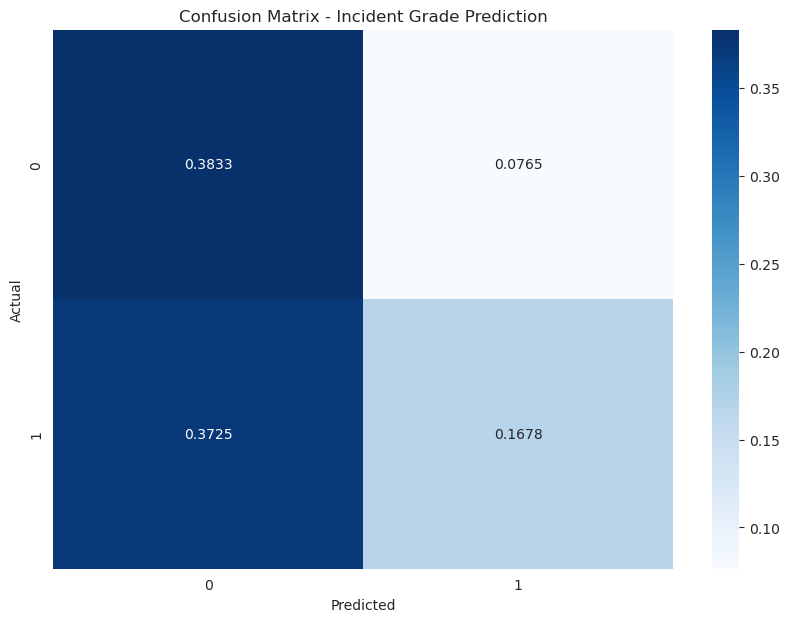

In [27]:
# Plot with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm/count, annot=True, fmt='.4f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Incident Grade Prediction')
plt.show()

KeyboardInterrupt: 

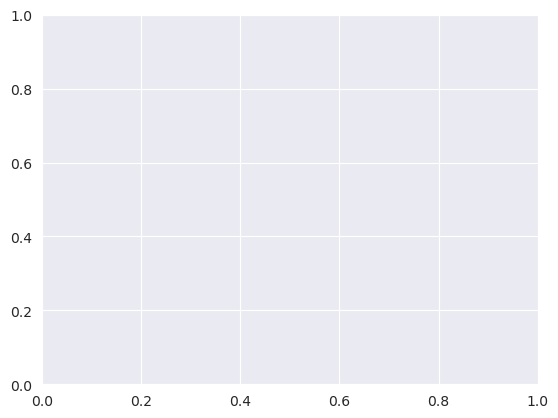

In [75]:
sns.barplot(df["alert"])

In [ ]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(labels, pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()